In [1]:
# General
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7)
mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.origin"] = "lower"
import pysynphot as S
from astropy.table import Table
import webbpsf
import scipy

# Grizli
import grizli
from grizli.model import GrismFLT

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
empty_dir = "/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/empty_direct.fits"
empty_seg = "/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/empty_seg.fits"
pad = 100
roman = GrismFLT(direct_file=empty_dir, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/empty_direct.fits / Pad ref HDU with 264 pixels
/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/empty_direct.fits / blot segmentation /Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-

In [3]:
# Define SED directory
SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs"

# Create Bandpass object
df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

# Read in star spectrum
src = webbpsf.specFromSpectralType('G0V', catalog='phoenix')
wave = np.linspace(10000,20000,10000) # Angstroms
flux = src(wave).value
star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam")
star_spec = star_spec.renorm(1, "abmag", bp)
star_spec.convert("flam")

# read in sensitivity file
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")
interpolated_sens = np.interp(wave, sens["WAVELENGTH"], sens["SENSITIVITY"])

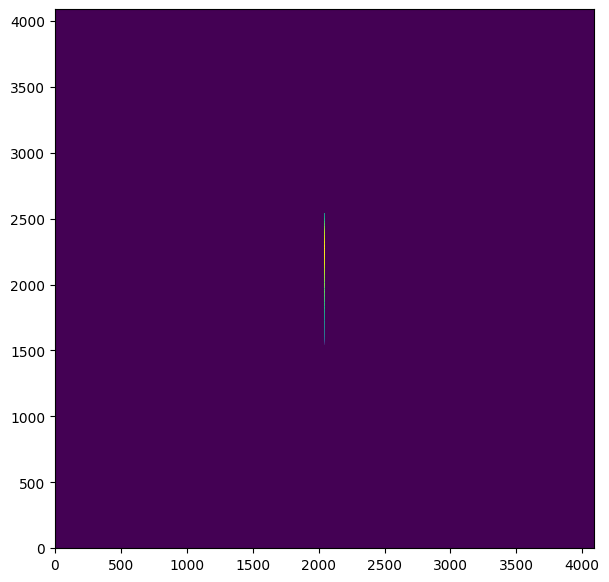

In [4]:
dir = np.zeros((4288,4288), dtype="float32") # pad=100
dir[2144, 2144] = 1.

roman.direct.data["SCI"] = dir
roman.seg = dir

model = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=5,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

upright = np.rot90(model[pad:-pad, pad:-pad])
plt.imshow(upright)

In [5]:
# Demonstrating our cutout dimensions are correct
upright[2044 - 502: 2044+501, 2043:2046]

array([[       0. ,        0. ,        0. ],
       [       0. ,  2372784.5,        0. ],
       [       0. ,  2536043.5,        0. ],
       ...,
       [       0. , 17811464. ,        0. ],
       [       0. , 17755318. ,        0. ],
       [       0. ,        0. ,        0. ]], dtype=float32)

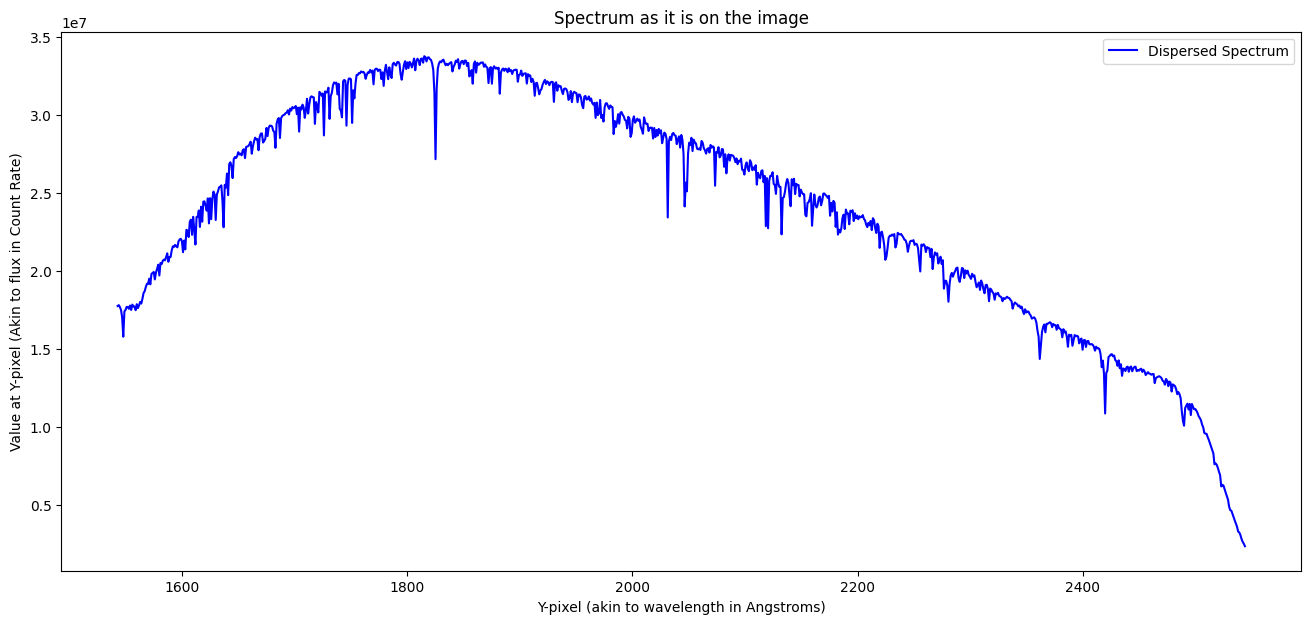

In [6]:
cutout = np.flip(upright[2044-501: 2044+500, 2044]) # proper limits are y=[-500:500], x=[2144]
pix = np.linspace(2044-501, 2044+500, len(cutout))

plt.plot(pix, cutout, c='b', label="Dispersed Spectrum")

plt.title("Spectrum as it is on the image")
plt.xlabel("Y-pixel (akin to wavelength in Angstroms)")
plt.ylabel("Value at Y-pixel (Akin to flux in Count Rate)")
plt.legend()

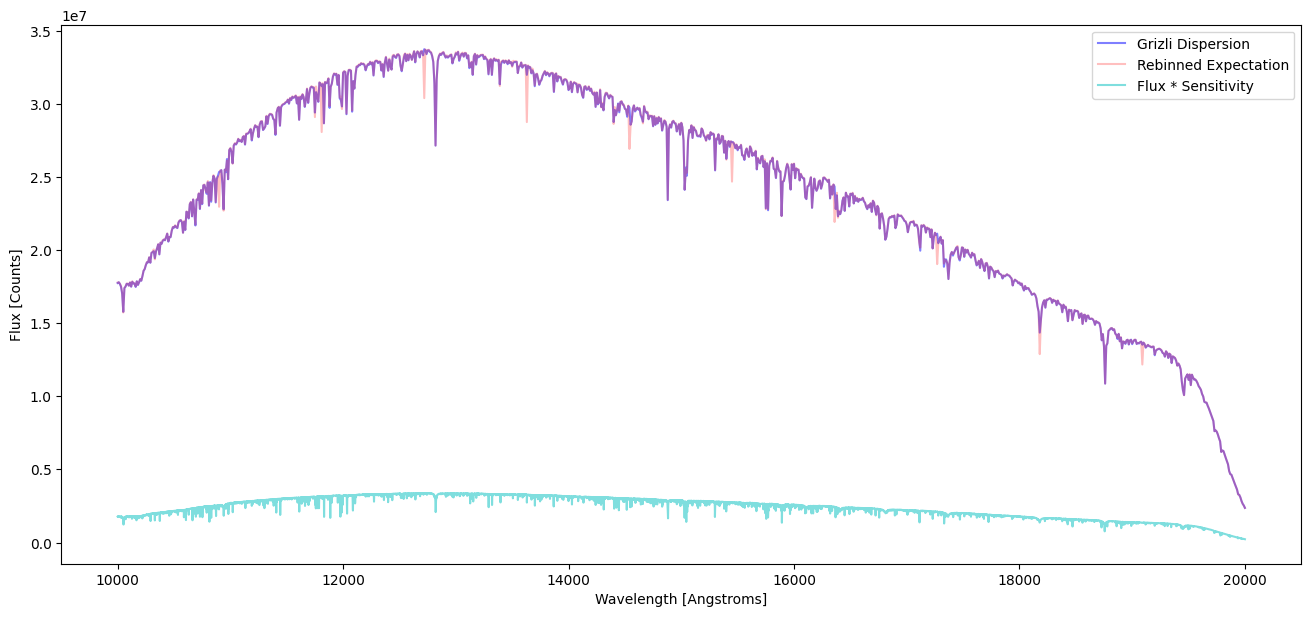

In [7]:
expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, len(cutout))

plt.plot(wave, cutout, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")
plt.plot(star_spec.wave, expected_values, c='c', alpha=0.5, label="Flux * Sensitivity")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.legend()

## Trying to repeat the experiment, but with a line instead of a point

(1900.0, 2200.0)

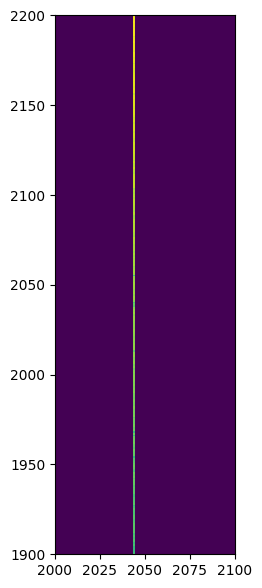

In [8]:
dir[2100:2200, 2144] = 1.

roman.direct.data["SCI"] = roman.seg = dir

mdoel = roman.compute_model_orders(id=1, mag=1, compute_size=False, size=77,
                                   in_place=False, store=False, is_cgs=True,
                                   spectrum_1d=[star_spec.wave, star_spec.flux])[1]

upright = np.rot90(model[pad:-pad, pad:-pad])
plt.imshow(upright)
plt.xlim(2000, 2100)
plt.ylim(1900, 2200)

In [9]:
cutout

array([17755318. , 17811464. , 17688716. , ...,  2656351. ,  2536043.5,
        2372784.5], dtype=float32)

In [10]:
cutout = np.flip(upright[2044-501: 2044+500, 2043:2046])

counts = []
for ii in range(cutout.shape[0]):
    counts.append(cutout[ii,:].sum())

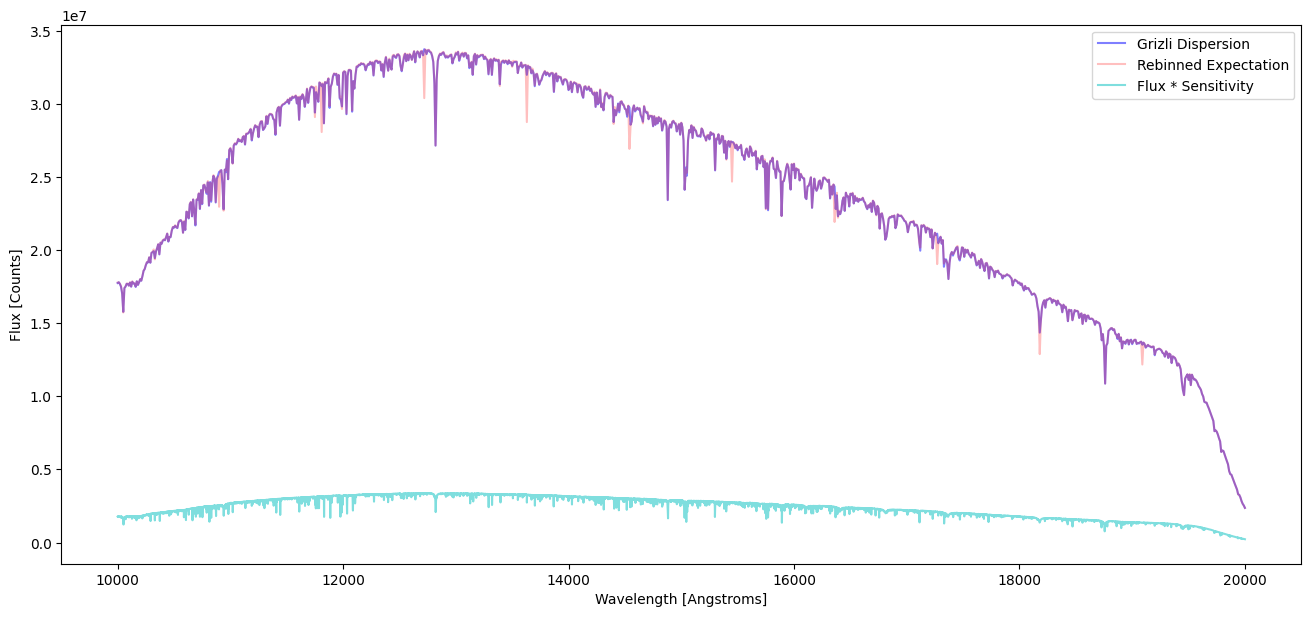

In [11]:
expected_values = star_spec.flux * interpolated_sens
binned_expectation = scipy.stats.binned_statistic(star_spec.wave, expected_values, statistic="sum", bins=1001)[0]
wave = np.linspace(10000, 20000, len(cutout))

plt.plot(wave, counts, c='b', alpha=0.5, label="Grizli Dispersion")
plt.plot(wave, binned_expectation, c='r', alpha=0.25, label="Rebinned Expectation")
plt.plot(star_spec.wave, expected_values, c='c', alpha=0.5, label="Flux * Sensitivity")

plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [Counts]")
plt.legend()